In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import numpy as np
df = pd.read_csv('VN_House_price_Clean2.csv')

In [2]:
# -----------------------------
# 1. Feature & Target
# -----------------------------
num_features = [	'Area',	'Access Road',	'Floors',	'Bedrooms',	'Bathrooms','Frontage']
cat_features = ['City', 'District','Legal status', 'Furniture state']
feature_cols = num_features + cat_features
target = "Price"

X = df[feature_cols].copy()
y = df[target]

# -----------------------------
# 2. LabelEncode categorical
# -----------------------------
for col in cat_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# -----------------------------
# 3. Scale numeric
# -----------------------------
scaler = StandardScaler()
X[num_features] = scaler.fit_transform(X[num_features])

# -----------------------------
# 4. Train/Test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [3]:
# ==========================================================
# 5. MODEL 1: XGBOOST
# ==========================================================
xgb_reg = xgb.XGBRegressor(
    n_estimators=500, 
    max_depth=6, 
    learning_rate=0.05,
    subsample=0.8, 
    colsample_bytree=0.8, 
    random_state=42
)
xgb_reg.fit(X_train, y_train)

y_pred_xgb = xgb_reg.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("===== XGBoost =====")
print(f"RMSE: {rmse_xgb:.2f}")
print(f"MAE:  {mae_xgb:.2f}")
print(f"R²:   {r2_xgb:.4f}\n")

===== XGBoost =====
RMSE: 1.26
MAE:  0.95
R²:   0.6658



In [4]:
# ==========================================================
# 6. MODEL 2: RANDOM FOREST
# ==========================================================
rf_reg = RandomForestRegressor(
    n_estimators=500,
    max_depth=15,
    random_state=42
)
rf_reg.fit(X_train, y_train)

y_pred_rf = rf_reg.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("===== Random Forest =====")
print(f"RMSE: {rmse_rf:.2f}")
print(f"MAE:  {mae_rf:.2f}")
print(f"R²:   {r2_rf:.4f}\n")

===== Random Forest =====
RMSE: 1.34
MAE:  1.01
R²:   0.6222



In [5]:
from sklearn.model_selection import GridSearchCV

# -------------------------------------------------------
# 1. Base model
# -------------------------------------------------------
xgb_base = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42
)

# -------------------------------------------------------
# 2. Hyperparameter grid (nhẹ, chạy nhanh nhưng tối ưu tốt)
# -------------------------------------------------------
param_grid = {
    'n_estimators': [400, 700],
    'max_depth': [5, 7],
    'learning_rate': [0.03, 0.05],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}


# -------------------------------------------------------
# 3. GridSearchCV
# -------------------------------------------------------
grid = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=1     # ⚠️ quan trọng: Windows cần n_jobs=1
)


grid.fit(X_train, y_train)

print("Best Parameters:")
print(grid.best_params_)

# -------------------------------------------------------
# 4. Train final model với best params
# -------------------------------------------------------
best_xgb = grid.best_estimator_

y_pred_best = best_xgb.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))
mae = mean_absolute_error(y_test, y_pred_best)
r2 = r2_score(y_test, y_pred_best)

print("\n===== XGBoost Optimized =====")
print(f"RMSE: {rmse:.3f}")
print(f"MAE:  {mae:.3f}")
print(f"R²:   {r2:.4f}")


Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best Parameters:
{'colsample_bytree': 0.8, 'learning_rate': 0.03, 'max_depth': 7, 'n_estimators': 700, 'subsample': 0.8}

===== XGBoost Optimized =====
RMSE: 1.250
MAE:  0.936
R²:   0.6725


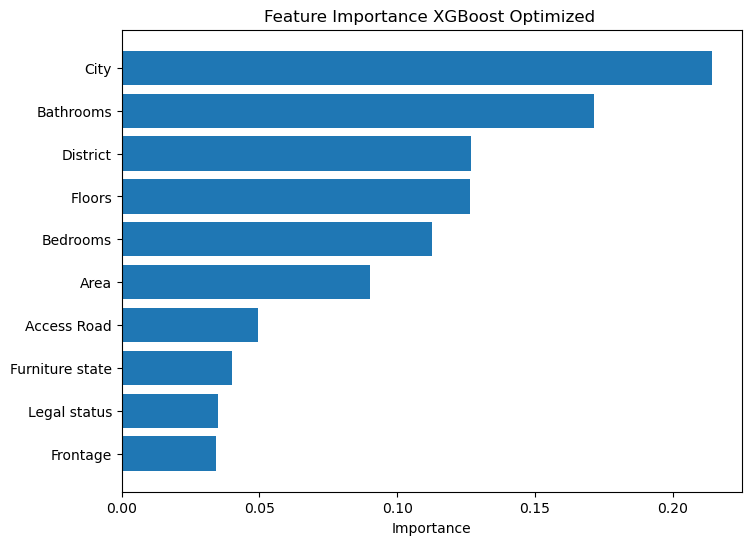

In [6]:
import matplotlib.pyplot as plt
importances = best_xgb.feature_importances_

feat_imp = pd.DataFrame({'Feature': feature_cols, 'Importance': importances})

# Sắp xếp theo Importance giảm dần
feat_imp = feat_imp.sort_values(by='Importance', ascending=True)

plt.figure(figsize=(8,6))
plt.barh(feat_imp['Feature'], feat_imp['Importance'])
plt.xlabel("Importance")
plt.title("Feature Importance XGBoost Optimized ")
plt.show()

In [7]:
best_xgb.save_model("xgboost_optimized.json")


In [8]:
loaded_model = xgb.XGBRegressor()
loaded_model.load_model("xgboost_optimized.json")
